In [1]:
import pandas as pd
import numpy as np
import cv2
import glob

import statistics
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer # bow of document
from sklearn.feature_extraction.text import TfidfVectorizer

import kiwipiepy
from kiwipiepy import Kiwi # 형태소 분석
from kiwipiepy.utils import Stopwords # kiwi 불용어

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'

import warnings
warnings.filterwarnings('ignore')

In [2]:
def Rep_text(text): # 단어 통일 시키기
    text = str(text)
    pattern = '(\n){1,}' 
    text = re.sub(pattern=pattern, repl='\n', string=text) # \n가 1번이상 사용된 경우 \n로 바꾸기
    return text

def Korean(text):
    text = str(text)
    text = text.replace("\n"," ")
    return re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text) # 최종으로 남길 문자들

# data load

In [3]:
df = pd.read_csv('../data/pre_data.csv')

df['preprocessed_best_comment'] = df['preprocessed_best_comment'].apply(lambda x: Rep_text(x)) # \n 반복되는 것 제거
df['preprocessed_comment'] = df['preprocessed_comment'].apply(lambda x: Rep_text(x)) # \n 반복되는 것 제거

df['preprocessed_best_comment'] = df['preprocessed_best_comment'].apply(lambda x: Korean(x))
df['preprocessed_comment'] = df['preprocessed_comment'].apply(lambda x: Korean(x))

# stopword 단어 추가하기

In [4]:
au_lst=[]
for a in list(df['author'].unique()): # #을 기준으로 작가 컬럼에 들어간 작가들 나누기
    au = a.split('#')[1:] # 0번째는 필요없으므로 제외
    for i in au: # 작가 리스트에 추가하기
        au_lst.append(i)
        
au_lst = list(set(au_lst)) # 작가 중복 제외

In [5]:
# stopword
file_path = 'stopwords.txt'  # 경로 지정
with open(file_path, 'r', encoding='utf-8') as file:
    word = file.read()

word = word.split('\n') # \n 구분
# stopword 추가하기
word_lst = ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', 
            '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', 
            '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', 
            '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', 
            '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', 
            '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', 
            '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', 
            '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', 
            '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', 
            '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', 
            '하기만', '하는', '하는것만', '하는것이', '하다', '하면', '하지', '한하다', '할수록', '함으로써', 
            '해도', '해서는', '형식으로', '힘이'] + au_lst

for w in word_lst:
    word.append(w)
stopwords = set(word)

## tokenize & stopword

In [6]:
stopwords = set(list(stopwords)+ ['클린','표현','감지','댓글','작가','웹툰','네이버']) # sropword 추가
kiwi_stop = Stopwords() # kiwi 불용어

kiwi = kiwipiepy.Kiwi()
def extract_noun(text):
    text = str(text)
    words = []
    for token in kiwi.tokenize(text, normalize_coda=True, stopwords=kiwi_stop): 
        # normalize_coda 옵션 사용, 덧붙은 받침 때문에 분석이 깨지는 경우 방지
        # stopwords 불용어 관리
        if (token.tag in {'NNG', 'NNP'}) & (token.form not in stopwords) & (len(token.form)>1): # kiwi 명사 추출. stopwords에 포함되는 단어 제거
            words.append(token.form)
    return words

df['pre_best_comment'] = df['preprocessed_best_comment'].apply(lambda x: extract_noun(x))

# LDA

In [10]:
from gensim import corpora
word_dict = corpora.Dictionary(df['pre_best_comment']) # 댓글들을 Dictionary로 생성

corpus = [word_dict.doc2bow(text) for text in df['pre_best_comment']] # 문서 데이터 수치화

In [26]:
# train, vaild 분리
from sklearn.model_selection import train_test_split
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=1)

## parameter tuning

In [32]:
# 최적의 p값 찾기
# pass: 모델 학습 시, 전체 corpus에서 모델을 학습시키는 빈도 제어. epocks와 같은 용어
import time
import gensim
from gensim.models.coherencemodel import CoherenceModel

coherences=[]
perplexities=[]

for i in range(10):
    N_TOPICS = 100
    if i==0:
        p=1
    else:
        p=i*5
    tic = time.time()
    lda4 = gensim.models.ldamodel.LdaModel(train_corpus, 
                                           id2word=word_dict, 
                                           num_topics=N_TOPICS, 
                                           iterations=400, # 각 문서에 대해 루프를 얼마나 돌릴지 제어
                                           passes=p)
    print('epoch',p,time.time() - tic)
    
    cm = CoherenceModel(model=lda4, corpus=valid_corpus, coherence='u_mass')
    coherence = cm.get_coherence() # coherence 구하기
    coherences.append(coherence)
    perplexities.append(lda4.log_perplexity(valid_corpus)) # log_perplexity 구하기
    print("Coherence",coherence)
    print('Perplexity: ', lda4.log_perplexity(valid_corpus),'\n\n')

epoch 1 23.98031759262085
Coherence -10.541056334720977
Perplexity:  -18.5971697581798 


epoch 5 79.15028786659241
Coherence -11.294618892481052
Perplexity:  -18.127593397006592 


epoch 10 142.0659155845642
Coherence -11.728076672864143
Perplexity:  -18.019576789483846 


epoch 15 202.81360745429993
Coherence -12.138250828443779
Perplexity:  -17.96894634768367 


epoch 20 263.647344827652
Coherence -11.135050265317853
Perplexity:  -17.992352651383236 


epoch 25 318.7898328304291
Coherence -11.483413922993803
Perplexity:  -17.966890199997387 


epoch 30 380.06589365005493
Coherence -11.654806363380779
Perplexity:  -17.933840663224917 


epoch 35 439.0877821445465
Coherence -11.99939122826409
Perplexity:  -17.947816854531794 


epoch 40 493.6461434364319
Coherence -11.5369679262196
Perplexity:  -17.975213666937595 


epoch 45 551.5459008216858
Coherence -11.096251636140112
Perplexity:  -17.97295613874704 




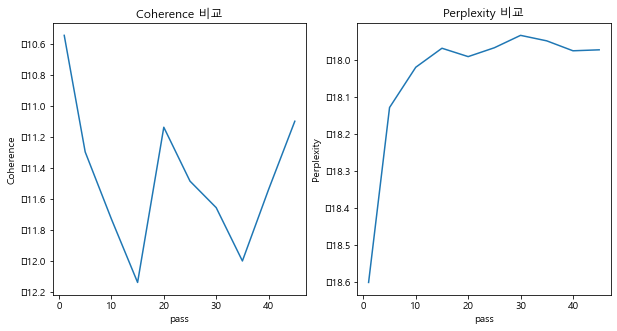

In [33]:
pass_lst = [1]+[i*5 for i in range(1,10)]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(pass_lst,coherences)
plt.xlabel('pass')
plt.ylabel('Coherence')
plt.title('Coherence 비교')

plt.subplot(1,2,2)
plt.plot(pass_lst,perplexities)
plt.xlabel('pass')
plt.ylabel('Perplexity')
plt.title('Perplexity 비교')

plt.show()

- p값은 20으로 선정

In [36]:
# topic 수 찾기
coherences_To=[]
perplexities_To=[]
topic_lst=[]
warnings.filterwarnings('ignore')

for i in range(10):
    if i==0:
        N_TOPICS = 5
    else:
        N_TOPICS = 20*i
    topic_lst.append(N_TOPICS)
    
    tic = time.time()
    lda4 = gensim.models.ldamodel.LdaModel(train_corpus, 
                                           id2word=word_dict, 
                                           num_topics=N_TOPICS, 
                                           iterations=400, 
                                           passes=20)
    print('N_TOPICS',N_TOPICS,time.time() - tic)

    cm = CoherenceModel(model=lda4, corpus=valid_corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    coherences_To.append(coherence) # coherence 구하기
    perplexities_To.append(lda4.log_perplexity(valid_corpus)) # 구하기 log_perplexity
    print("Coherence",coherence)
    print('Perplexity: ', lda4.log_perplexity(valid_corpus),'\n\n')

N_TOPICS 5 72.96005725860596
Coherence -4.099460914394726
Perplexity:  -8.59374720663071 


N_TOPICS 20 84.91420459747314
Coherence -6.297194595023639
Perplexity:  -9.967841654447934 


N_TOPICS 40 271.8848569393158
Coherence -6.598559738967481
Perplexity:  -11.48847996825008 


N_TOPICS 60 153.0169711112976
Coherence -7.236123559190387
Perplexity:  -13.018286773745995 


N_TOPICS 80 872.6967356204987
Coherence -7.4790231829053555
Perplexity:  -14.579142934944068 


N_TOPICS 100 262.18274211883545
Coherence -7.676944065365077
Perplexity:  -16.157575586995915 


N_TOPICS 120 336.2375349998474
Coherence -8.180782601327737
Perplexity:  -17.730934521553912 


N_TOPICS 140 400.44246459007263
Coherence -8.212491916617676
Perplexity:  -19.346228692505086 


N_TOPICS 160 471.90199732780457
Coherence -8.363908057764554
Perplexity:  -20.940407938326835 


N_TOPICS 180 525.6146731376648
Coherence -8.695505100079469
Perplexity:  -22.559927441716123 




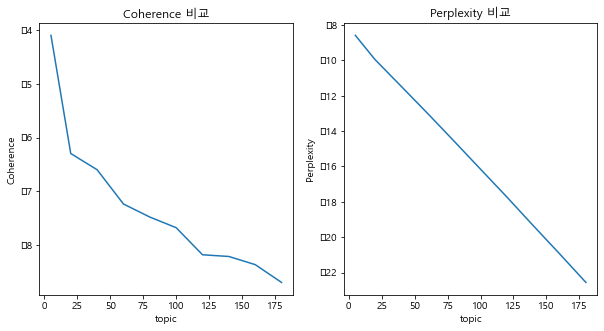

In [37]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(topic_lst,coherences_To)
plt.xlabel('topic')
plt.ylabel('Coherence')
plt.title('Coherence 비교')

plt.subplot(1,2,2)
plt.plot(topic_lst,perplexities_To)
plt.xlabel('topic')
plt.ylabel('Perplexity')
plt.title('Perplexity 비교')

plt.show()

- topic 수는 60으로 결정

## LDA topic=60, p=20으로 train

In [42]:
# LDA모델 훈련 (topic=60)
import gensim
N_TOPICS = 60
p=20
ldamodel = gensim.models.ldamodel.LdaModel(train_corpus, 
                                           num_topics = N_TOPICS, 
                                           id2word=word_dict, 
                                           passes = p, 
                                           random_state=1)

In [43]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=ldamodel, corpus=valid_corpus, coherence='u_mass')
coherence = cm.get_coherence()# 주제의 일관성 측정 (높을 수록 의미론적 일관성 높음)
loss = ldamodel.log_perplexity(valid_corpus) # 특정 확률 모델이 실제 관측되는 값을 얼마나 잘 예측하는지 (작은게 문서를 잘 반영.but 낮다고 해서 결과가 해석 용이하다는 것은 아님)
print(coherence,loss)

-9.767206333029499 -14.433406843377465


In [45]:
ldamodel.save('lda-model')
# model = LdaModel.load('lda-model')

In [53]:
topics = ldamodel.print_topics(num_words=5) # 주제 당 포함할 단어 수 5개
for topic in topics:
    print(topic)

(56, '0.087*"수아" + 0.037*"소대" + 0.028*"시현" + 0.024*"후임" + 0.020*"말년"')
(47, '0.025*"가빈" + 0.020*"태웅" + 0.018*"전설" + 0.012*"소월" + 0.012*"우승"')
(53, '0.016*"가능" + 0.015*"능력" + 0.012*"정도" + 0.011*"싸움" + 0.010*"세계관"')
(6, '0.024*"지각" + 0.016*"카엘" + 0.015*"휴재" + 0.013*"담당자" + 0.013*"헤스"')
(23, '0.093*"여주" + 0.037*"결혼" + 0.036*"지우" + 0.024*"쿠키" + 0.021*"연애"')
(55, '0.025*"시아" + 0.024*"일진" + 0.023*"소연" + 0.020*"학년" + 0.018*"머리"')
(59, '0.094*"가을" + 0.053*"유현" + 0.038*"효민" + 0.019*"유형" + 0.019*"고수"')
(1, '0.085*"추이" + 0.049*"호랑이" + 0.035*"무게" + 0.031*"귀신" + 0.029*"눈썹"')
(15, '0.043*"라헬" + 0.030*"유리" + 0.029*"하드" + 0.019*"자하드" + 0.018*"인원"')
(31, '0.036*"스토리" + 0.025*"분량" + 0.023*"내용" + 0.023*"생각" + 0.023*"만화"')
(29, '0.047*"독자" + 0.019*"팬티" + 0.015*"일본" + 0.015*"이름" + 0.015*"감독자"')
(7, '0.028*"지웅" + 0.021*"예지" + 0.018*"로이드" + 0.017*"당근" + 0.016*"재료"')
(16, '0.019*"지민" + 0.015*"운전" + 0.014*"재하" + 0.013*"눈앞" + 0.012*"유은"')
(8, '0.018*"나라" + 0.015*"배추" + 0.013*"현실" + 0.012*"세희" + 0.010*"국가"')
(38

# LDAvis를 통한 시각화

In [48]:
# !pip install pyLDAvis 

In [49]:
# LDA 시각화
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, word_dict)
pyLDAvis.display(vis)

In [54]:
# 문서 별 토픽 분포
for i, topic_list in enumerate(ldamodel[corpus]):
    print(f'{i}번째 문서의 topic 비중: {topic_list}')
    if i==4:
        break

0번째 문서의 topic 비중: [(3, 0.021740299), (6, 0.043838542), (7, 0.02077139), (10, 0.1458196), (16, 0.021791901), (17, 0.14371285), (19, 0.022813102), (22, 0.021627583), (31, 0.19055267), (35, 0.02111472), (38, 0.04402763), (39, 0.100987285), (46, 0.022349738), (54, 0.1631788)]
1번째 문서의 topic 비중: [(3, 0.011252392), (7, 0.013229946), (10, 0.12072274), (13, 0.028787043), (24, 0.02638254), (25, 0.051706005), (31, 0.28270367), (38, 0.03273558), (46, 0.02492647), (47, 0.022335423), (54, 0.3026373), (55, 0.06648899)]
2번째 문서의 topic 비중: [(6, 0.026027124), (8, 0.035994668), (10, 0.20708627), (13, 0.09105279), (16, 0.03608484), (28, 0.023983443), (30, 0.023592228), (31, 0.061916422), (42, 0.020409627), (54, 0.2122185), (55, 0.2452884)]
3번째 문서의 topic 비중: [(10, 0.0689622), (13, 0.06086172), (20, 0.13253438), (24, 0.083682455), (25, 0.043399684), (30, 0.05553172), (54, 0.511612), (55, 0.025352428)]
4번째 문서의 topic 비중: [(0, 0.02191056), (7, 0.041402437), (10, 0.24746022), (12, 0.02004881), (13, 0.047062963),

In [55]:
# 각 문서에 대해서 topic의 비중 나타내는 함수
def get_topic_ratio_for_each_document(ldamodel, corpus):
    results = []
    for i, topic_list in enumerate(ldamodel[corpus]):
        sorted_topic_list = sorted(topic_list, key = lambda x: x[1], reverse=True)
        most_important_topic, most_important_ratio = sorted_topic_list[0]
        doc_result = [i, most_important_topic, most_important_ratio, sorted_topic_list]
        results.append(doc_result)
        
    results = pd.DataFrame(results, columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중'])
    return results

df_results = get_topic_ratio_for_each_document(ldamodel, corpus)

In [75]:
def matching_topic(top_lst, id_token):
    lst = []
    for i in range(len(top_lst)):
        topp = top_lst[i][0]
        percent = top_lst[i][1]
        
        ne_to = id_token[topp]
        
        lst.append((ne_to,percent))
        
    return lst

df_results['id to topic'] = df_results['각 토픽의 비중'].apply(lambda x: matching_topic(x,word_dict.id2token))

In [76]:
df_results

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중,id to topic
0,0,31,0.190519,"[(31, 0.19051945), (54, 0.16309771), (10, 0.14...","[(이웃, 0.19051945), (납득, 0.16309771), (대박, 0.14..."
1,1,54,0.302616,"[(54, 0.30261597), (31, 0.28271583), (10, 0.12...","[(납득, 0.30261597), (이웃, 0.28271583), (대박, 0.12..."
2,2,55,0.245323,"[(55, 0.24532312), (54, 0.2122135), (10, 0.207...","[(느낌, 0.24532312), (납득, 0.2122135), (대박, 0.207..."
3,3,54,0.511616,"[(54, 0.5116159), (20, 0.13272327), (24, 0.083...","[(납득, 0.5116159), (사랑, 0.13272327), (세리머니, 0.0..."
4,4,54,0.296692,"[(54, 0.29669172), (10, 0.24742278), (39, 0.10...","[(납득, 0.29669172), (대박, 0.24742278), (헐도, 0.10..."
...,...,...,...,...,...
18359,18359,36,0.424516,"[(36, 0.42451617), (54, 0.1596926), (11, 0.080...","[(타라, 0.42451617), (납득, 0.1596926), (독자, 0.080..."
18360,18360,20,0.330550,"[(20, 0.33054993), (36, 0.27376574), (41, 0.11...","[(사랑, 0.33054993), (타라, 0.27376574), (혁명, 0.11..."
18361,18361,39,0.255586,"[(39, 0.25558576), (36, 0.15074432), (20, 0.15...","[(헐도, 0.25558576), (타라, 0.15074432), (사랑, 0.15..."
18362,18362,36,0.354003,"[(36, 0.35400268), (20, 0.144072), (41, 0.1254...","[(타라, 0.35400268), (사랑, 0.144072), (혁명, 0.1254..."


# topic 해석

In [80]:
# 토픽을 문자로 표현하는 함수
def get_topic_labels(lda_model, dictionary):
    topic_labels = []
    for topic_id in range(lda_model.num_topics):
        topic_terms = lda_model.get_topic_terms(topic_id)
        topic_words = [dictionary[term_id] for term_id, _ in topic_terms]
        topic_labels.append(', '.join(topic_words))
    return topic_labels

topic_labels = get_topic_labels(ldamodel, word_dict.id2token)

# 결과 출력
for topic_id, label in enumerate(topic_labels):
    print(f"Topic {topic_id + 1}: {label}")

Topic 1: 엄마, 아빠, 동생, 아버지, 아들, 어머니, 가족, 부모, 자식, 아저씨
Topic 2: 추이, 호랑이, 무게, 귀신, 눈썹, 부하, 정도, 늑대, 포스, 인간
Topic 3: 부장, 납치, 실장, 환자, 승부, 직원, 장기, 팔찌, 무기, 연관
Topic 4: 대리, 여왕, 벌레, 한희, 민지, 아영, 과장, 민영, 정동, 능력
Topic 5: 매화, 청명, 화산, 머리카락, 손빈, 귀환, 소원, 맛집, 대머리, 만화
Topic 6: 김신, 캐슬, 진태, 구스타프, 검열, 남궁, 김대건, 피우진, 킬러, 바리스타
Topic 7: 지각, 카엘, 휴재, 담당자, 헤스, 특별, 도로, 공지, 엽리, 보완
Topic 8: 지웅, 예지, 로이드, 당근, 재료, 베도, 정도, 레시피, 갈비, 아비
Topic 9: 나라, 배추, 현실, 세희, 국가, 집단, 한국, 사건, 문제, 우리나라
Topic 10: 정태, 왼쪽, 현우, 상향, 태훈이, 개학, 수련회, 모바일, 와꾸, 원가
Topic 11: 경우, 민지, 공주, 왕자, 주영이, 자림, 친구, 혁명, 자림이, 연애
Topic 12: 교수, 대학원, 선배, 생각, 여우, 장가, 우주, 박사, 졸업, 연애
Topic 13: 선생, 할머니, 재익, 총명, 담배, 바리, 주희, 화주, 학교, 교장
Topic 14: 수원, 버스, 자가, 박동, 어머님, 기사, 기량, 근무, 시절, 바보
Topic 15: 지우, 고양이, 능력, 카이, 지석, 각성, 카르테, 유지영, 주주, 대표
Topic 16: 라헬, 유리, 하드, 자하드, 인원, 랭커, 가문, 화이트, 신수, 공주
Topic 17: 지민, 운전, 재하, 눈앞, 유은, 학살, 시어머니, 스릴러, 특집, 이진호
Topic 18: 치료, 운동, 영하, 출근, 전기, 합격, 계산, 면접, 한림, 허리
Topic 19: 기명, 요한, 낭만, 장현, 빅딜, 싸움, 크루, 세대, 호스텔, 헤드
Topic 20: 준수, 선수, 마루, 상호, 경기, 농구, 감독, 태성이,